# Исследование объявлений о продаже квартир


**Цель исследования:**  
Необходимо выявить основные параметры и факторы, влияющие на рыночную цену квартиры. Это позволит отследить аномалии и мошенническую деятельность при автоматизации процесса оценки.

**Входные данные:**  
Архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет (файл `real_estate_data.csv`).

**Ход исследования:**  
О качестве данных ничего не известно, кроме того, что одна часть информации была указана пользователями самостоятельно, другая — получена автоматически на основе картографических данных (например, расстояние до центра, аэропорта, ближайшего парка и водоёма).

Мы проверим данные на ошибки и оценим их влияние на исследование; затем, на этапе предобработки поищем возможность исправить самые критичные ошибки. Далее проведём расчёты, на основании которых проанализируем данные и выявим параметры, влияющие на ценообразование квартиры.

**Этапы исследования**:
1. Обзор данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Общий вывод


### Обзор данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
display(data.head()) # Выводим первые строки

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
# Выведем оснонвную информацию с помощью метода info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

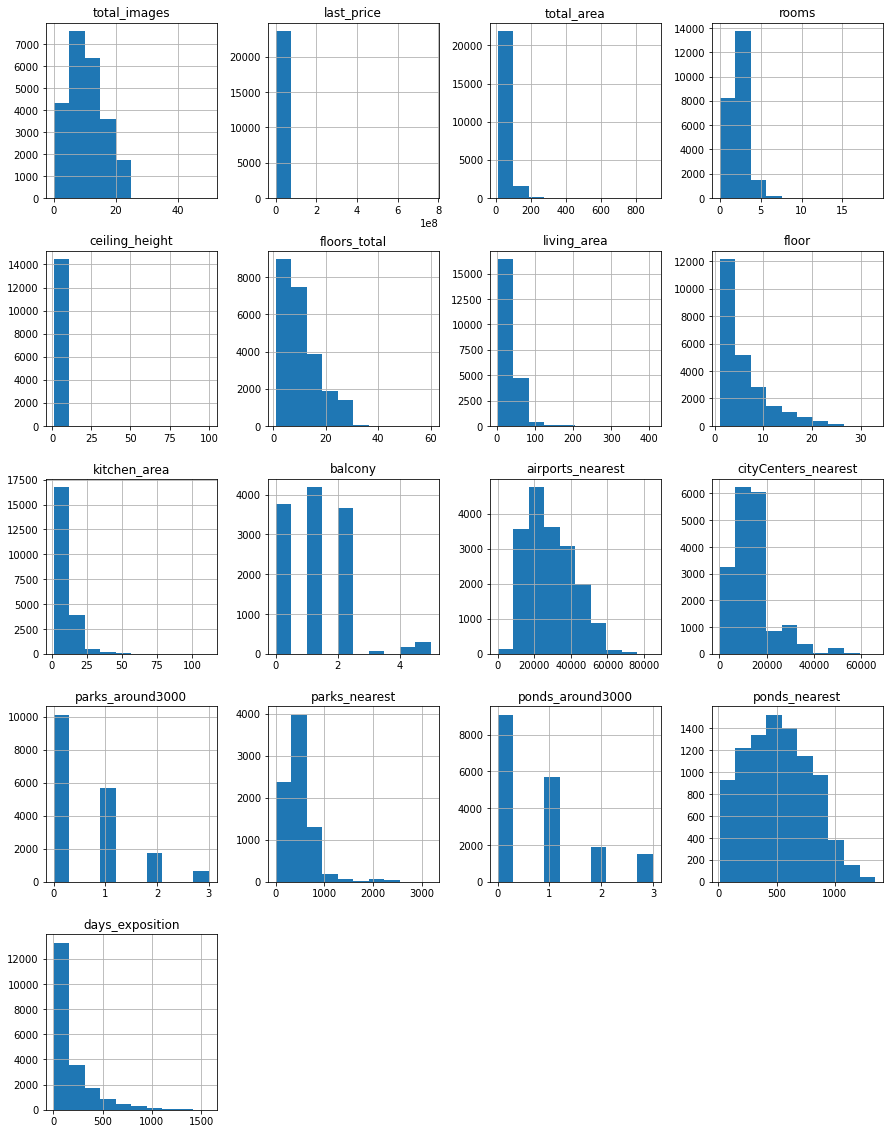

In [4]:
# Строим гистограммы
data.hist(figsize=(15, 20));

Данные представлены в виде таблицы, включающей в себя 23 698 строк и 22 столбца. При этом 3 столбца - с целочисленными данными (тип < int >), 14 столбцов - с числовыми данными типа < float >, 3 столбца типа < object > и 2 столбца с булевым типом (тип < bool >).

Из полученных гистрограм мы видим, что некоторые колонки заставляют усомниться в качестве данных, например колонка ceiling_height с максимальной высотой потолка в 100 метров

### Предобработка данных

In [5]:
# Выведем кол-во пропущенных значений для каждого столбца
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Описание пропущенных значений:

— 9195 ceiling_height - практически в трети объявлений пропущена высота потолков, можно заполнить медианой (2.65) 

— 86 floors_total - данный признак будет использоваться в анализе, при этом достаточно точно заменить пропущенные значения не представляется возможным, поэтому все строки с пропущенными значениями удалим

— 1903 living_area и 2278 kitchen_area  - можно препдположить, что если нам известна общая площадь недвижимости, то мы можем оценить, сколько квадратных метров составляет жилая площадь и площадь кухни на основе уже заполненных данных

— 2775 is_apartment - можем предположить что это не апартаменты и присвоить False

— 11519 balcony - скорее всего там нет балконов, заполняем 0

— 49 locality_name - данные просто не заполнили, удалим данные строки, так как они будут использоваться при дальнейшем анализе, а заполнить их не представляется возможным

— 5542 airports_nearest - аэропортов рядом нет, оставляем Null

— 5519 city_centers_nearest - центр города не близко, оставляем Null

— 5518 parks_around3000 - значит парков нет в радиусе 3км, оставляем Null

— 15620 parks_nearest - значит парков нет, оставляем Null

— 5518 ponds_around3000 - значит прудов нет в радиусе 3км, оставляем Null

— 14589 ponds_nearest - оставляем Null

— 3181 days_exposition -  оставляем Null


In [8]:
# Заполним пропущенные значения

data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data.dropna(subset=['floors_total'], inplace=True) # этажи в доме
data['is_apartment'] = data['is_apartment'].fillna(False) # апартаменты
data['balcony'] = data['balcony'].fillna(0) # балконы
data.dropna(subset=['locality_name'], inplace=True) # название населённого пункта


# Расчет среднего коэффициента отношения жилой площади к общей площади
mean_living_ratio = data['living_area'].mean() / data['total_area'].mean()

# Расчет среднего коэффициента отношения площади кухни к общей площади
mean_kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()

# Заполнение пропущенных значений в столбцах с использованием средних коэффициентов
data['living_area']= data['living_area'].fillna(data['total_area'] * mean_living_ratio)
data['kitchen_area']= data['kitchen_area'].fillna(data['total_area'] * mean_kitchen_ratio)

# Также переименуем столбец cityCenters_nearest в соответствии с snake_case
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)

In [9]:
# проведём проверку на корректность значений всех наших площадей
anomalies = data.query('total_area*0.9 <= (living_area + kitchen_area)')
# Выведем аномалии, если они есть
if not anomalies.empty:
    print("Найдены аномалии в значениях площадей:")
    print(anomalies)

Найдены аномалии в значениях площадей:
       total_images  last_price  total_area first_day_exposition  rooms  \
41               16   7900000.0        74.0  2016-05-04T00:00:00      3   
171               6   3800000.0        49.0  2019-02-22T00:00:00      2   
184               7   2600000.0        30.2  2018-02-14T00:00:00      1   
220               8   3890000.0        37.0  2018-07-09T00:00:00      1   
319              19   4850000.0        59.7  2015-03-19T00:00:00      3   
...             ...         ...         ...                  ...    ...   
23297            10   1850000.0        48.2  2019-03-13T00:00:00      2   
23328            12   4299000.0        54.0  2016-11-25T00:00:00      2   
23521            13   8500000.0        65.0  2018-11-01T00:00:00      2   
23579             7   2350000.0        24.8  2018-06-07T00:00:00      1   
23680            14   5000000.0        59.0  2019-04-04T00:00:00      3   

       ceiling_height  floors_total  living_area  floor  is_

После внимательного анализа данных обнаружено, что некоторые квартиры демонстрируют аномалии в значениях площадей после процесса заполнения пропусков. Эти аномалии могут быть обусловлены различными факторами, такими как архитектурные особенности, изменения в структуре помещений, или возможные ошибки при сборе данных.

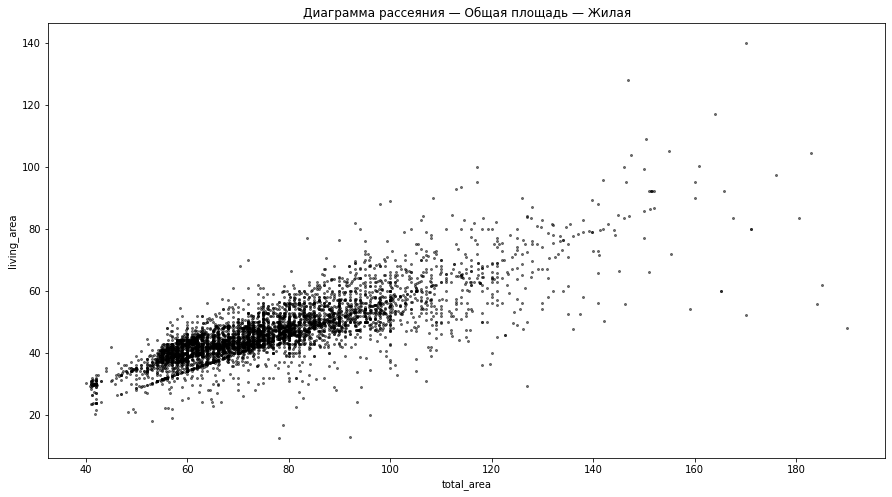

In [10]:
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

In [11]:
# Замена типов данных 

#first_day_exposition — дата публикации, установим тип данных data, чтобы работать с датой в дальнейшем было удобно
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

# Измененим тип is_apartment на bool, чтобы работать с булевым значением и сэкономить память.
data['is_apartment'] = data['is_apartment'].astype('bool')
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')

# Проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

In [12]:
# Исследуем столбец locality_name на предмет уникальных значений
print('Количество уникальных значений:', data['locality_name'].nunique())
data['locality_name'].unique()

Количество уникальных значений: 364


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Устранение неявных дубликатов:

 1) Привести все названия к нижнему регистру
 
 2) Заменить все названия поселок на посёлок
 
 3) Заменить все названия городской посёлок на посёлок городского типа, так как это одно и то же

In [13]:
# Замечены неявные дубликаты, приведём значения к нижнему регистру для избавления от дубликатов
data['locality_name'] = data['locality_name'].str.lower()

# Выполним замену ошибки в написании 'поселок' вместо 'посёлок':
data['locality_name'] = data['locality_name'].str.replace('поселок','посёлок')

# Замена однотипный значений
data['locality_name'] = data.locality_name.str.replace('городской посёлок', 'посёлок городского типа')

# Уникальные значения в алфавитном порядке
display(data['locality_name'].unique())

array(['санкт-петербург', 'посёлок шушары',
       'посёлок городского типа янино-1', 'посёлок парголово',
       'посёлок мурино', 'ломоносов', 'сертолово', 'петергоф', 'пушкин',
       'деревня кудрово', 'коммунар', 'колпино',
       'посёлок городского типа красный бор', 'гатчина',
       'деревня фёдоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'посёлок металлострой',
       'посёлок городского типа лебяжье',
       'посёлок городского типа сиверский', 'посёлок молодцово',
       'посёлок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'посёлок аннино',
       'посёлок городского типа ефимовский', 'посёлок плодовое',
       'деревня заклинье', 'посёлок торковичи', 'посёлок первомайское',
       'красное село', 'посёлок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'посёл

In [14]:
# check
data.locality_name.nunique()

323

In [15]:
# Проверим явные дубликаты
print('Количетво явных дубликатов:', data.duplicated().sum())

Количетво явных дубликатов: 0


Посмотрим на распределение значений в данных

In [16]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,18041.000000,18064.000000,18065.000000,8030.000000,18065.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.724530,10.675875,34.592277,5.878124,10.499898,0.593677,28797.082701,14192.656056,0.611569,490.580448,0.769499,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,0.991026,6.594823,22.373679,4.871485,6.037750,0.960660,12632.499735,8613.348153,0.802088,341.572956,0.938669,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26757.000000,13096.500000,0.000000,455.000000,1.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.700000,16.000000,42.100000,8.000000,12.000000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Квартир стоимостью 0: 0
Квартир стоимостью меньше 100.000: 1
Квартир стоимостью больше 100.000.000: 37


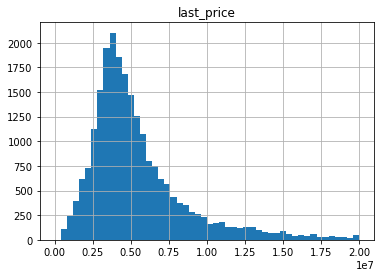

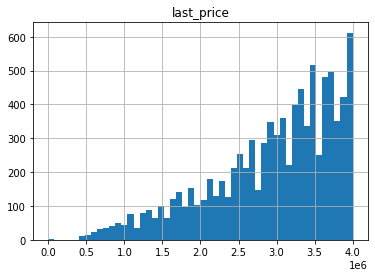

In [17]:
# проверим на аномалии стоимость квартир
print('Квартир стоимостью 0:', data.query('last_price == 0')['last_price'].count())
print('Квартир стоимостью меньше 100.000:', data.query('last_price < 1e+05')['last_price'].count())
print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())

data.hist('last_price', bins=50, range=(0,2e+07));
data.hist('last_price', bins=50, range=(0,4e+06));

Как видим, квартир, стоимостью 0 нет, есть только одна квартира стоимостью меньше 100.000 - уберём её. Также есть 37 квартир, стоимостью больше 100млн, можно их убрать, так как они слишком дорогие.

In [18]:
data.drop(index=data.query('last_price < 1e+05').index,inplace=True)
data.drop(index=data.query('last_price > 1e+08').index,inplace=True)

Квартир площадью менее 10 кв.м.: 0
Квартир площадью более 400 кв.м.: 14


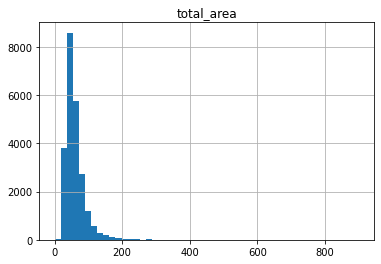

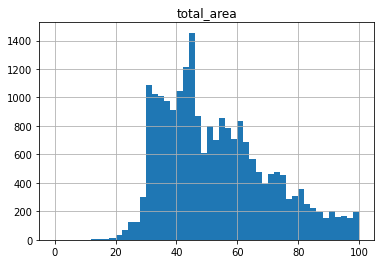

In [19]:
# проверим на аномалии площадь квартир
print('Квартир площадью менее 10 кв.м.:',data.query('total_area < 10')['total_area'].count()) 
print('Квартир площадью более 400 кв.м.:',data.query('total_area > 400')['total_area'].count())

data.hist('total_area', bins=50, range=(0,900));
data.hist('total_area', bins=50, range=(0,100));

Нет квартир меньше 10 кв.м, но есть квартиры более 400 кв.м, похоже, это элитная недвижимость, которая встречается очень редко, можно удалить

In [20]:
data.drop(index=data.query('total_area > 400').index,inplace=True)

In [21]:
# Проверим высоту потолков на аномалии
print('Квартиры с потолком ниже 1 метра',data.query('ceiling_height < 1')\
      ['ceiling_height'].count())
print('Квартир с потолками от 4 до 25м: ' , data.query('ceiling_height > 4 and ceiling_height < 25')\
      ['ceiling_height'].count())
print('Квартир с потолками от 25м до 36м: ' , data.query('ceiling_height >= 25 and ceiling_height <= 36')\
      ['ceiling_height'].count())
print('Квартиры с потолком выше 36 метров', data.query('ceiling_height > 36')\
      ['ceiling_height'].count())

Квартиры с потолком ниже 1 метра 0
Квартир с потолками от 4 до 25м:  48
Квартир с потолками от 25м до 36м:  19
Квартиры с потолком выше 36 метров 1


Квартиры, с высотой потолков от 4 до 25 метров удалим, так как это не похоже на правду
Для квартир с высотой потолков от 25 до 36 метров предполагаем, что это опечатка и делим на 10.
Также удалим квартиры, высота потолков которых выше 36 метров

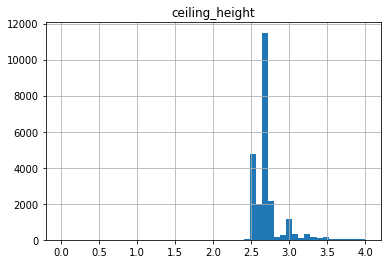

In [22]:
data.drop(index=data.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)
#обновимя квартиры с высотой потолков от 25 до 32 метров, /10
data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 32)]['ceiling_height']/10)

data.drop(index=data.query('ceiling_height > 32').index,inplace=True)

data.hist('ceiling_height',bins=50,range=(0,4));

In [23]:
# Нас не интересуют квартиры с высотой потолков менее 2.5м, это не по СНиПу. Удаляем из выборки.
data.drop(index=data.query('ceiling_height < 2.5').index,inplace=True)

In [24]:
print('Квартиры без комнат:',data.query('rooms == 0')['rooms'].count())

print('Квартиры без комнат и студии:',data.query('rooms == 0 and studio')['rooms'].count()) 

print('Квартиры без комнат и апартаменты:',data.query('rooms == 0 and is_apartment')['rooms'].count()) 

print('Квартиры без комнат и свободная планировка:',data.query('rooms == 0 and open_plan')['rooms']\
      .count())

print('Квартиры без комнат не апартаменты и не свободная планировка:',\
      data.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())
data.drop(index=data.query('rooms > 7').index,inplace=True)

Квартиры без комнат: 193
Квартиры без комнат и студии: 134
Квартиры без комнат и апартаменты: 0
Квартиры без комнат и свободная планировка: 59
Квартиры без комнат не апартаменты и не свободная планировка: 0


rooms - есть нулевые значенияdays_exposition.
Не будем торопится, проверим, может это студии, апартаменты или свободная планировка?
Похоже так и есть.
Квартиры без комнат не апартаменты и не свободная планировка - 0.
Максимальное значение аж 19 комнат, но такое тоже бывает.

Квартир в одноэтажных домах :  23
Квартир в 30+ этажных домах :  31


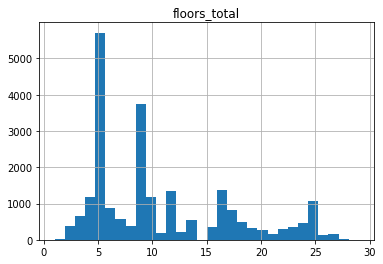

In [25]:
print('Квартир в одноэтажных домах : ',data.query('floors_total == 1')['floors_total'].count())
print('Квартир в 30+ этажных домах : ',data.query('floors_total > 30')['floors_total'].count())

data.drop(index=data.query('floors_total > 30').index,inplace=True)

data.hist('floors_total', bins=30);

floors_total - Есть одноэтажные квартиры,но это не похоже на выброс. Так же есть небольшое количество квартир в 30 и более этажных домах, что тоже имеет место быть

Жилая площадь меньше 10 кв.м.:  31
Жилая площадь больше общей:  0
Жилая площадь больше 200:  12


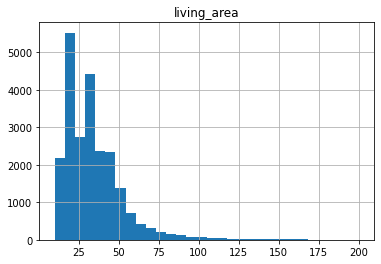

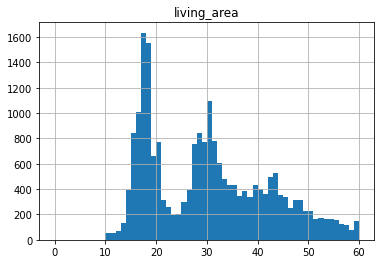

In [26]:
print('Жилая площадь меньше 10 кв.м.: ',data.query('living_area < 10')['living_area'].count())
print('Жилая площадь больше общей: ',data.query('living_area > total_area')['living_area'].count())
print('Жилая площадь больше 200: ',data.query('living_area > 200')['living_area'].count())

data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

data.hist('living_area', bins=30);
data.hist('living_area', bins=60, range=(0,60));

living_area - Имеем большое количество квартир с жилой площадью от 10 до 60 кв.м.
Здесь интерсуют квартиры с жилой площадью меньше 10 кв.м. их 31!
Отбросим значения с жилой площадью меньше 10кв.м.
Отбросим квартиры с площадью более 200 кв.м.

Площадь кухни меньше 2 кв.м.:  1
Площадь кухни 5 кв.м.:  355
Площадь кухни больше 50 кв.м.:  36
Площадь кухни больше общей:  0


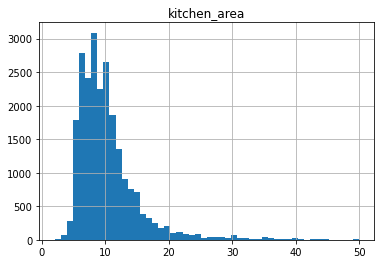

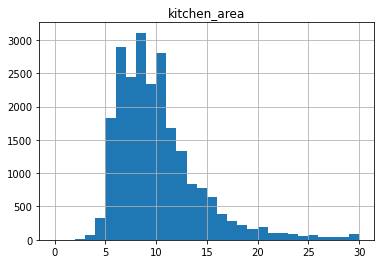

In [27]:
print('Площадь кухни меньше 2 кв.м.: ',data.query('kitchen_area < 2')['living_area'].count())
print('Площадь кухни 5 кв.м.: ',data.query('kitchen_area == 5')['living_area'].count())
print('Площадь кухни больше 50 кв.м.: ',data.query('kitchen_area > 50')['living_area'].count())
print('Площадь кухни больше общей: ',data.query('kitchen_area > total_area')['living_area'].count())

data.drop(index=data.query('kitchen_area < 2').index,inplace=True)
data.drop(index=data.query('kitchen_area > 50').index,inplace=True)

data.hist('kitchen_area', bins=50);
data.hist('kitchen_area', bins=30, range=(0,30));

kitchen_area - площадь кухни. Здесь есть одна квартира с площадью кухни меньше 1 кв. метра. Явно аномалия.
Немало кухонь с площадью 5 кв.м. Кухонь с площадью более 30 кв.м. довольно мало.
Удалим строки с кухнами менее 2кв.м. и больше 50кв.м.

Объявление не было оопубликовано:  0
Объявлению больше 3 лет :  163


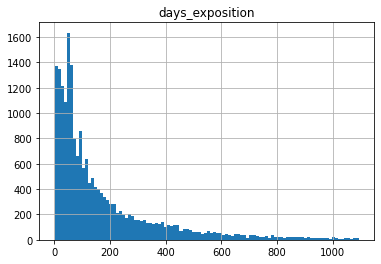

In [28]:
print('Объявление не было оопубликовано: ',data.query('days_exposition == 0')['days_exposition'].count())

print('Объявлению больше 3 лет : ',data.query('days_exposition > 365*3')['days_exposition'].count())

data.drop(index=data.query('days_exposition > 365*3').index,inplace=True)

data.hist('days_exposition', bins=100);

days_exposition - сколько дней было размещено объявление видим, что в целом график нормальный. Нулевых значений нет. Объявления, которые висели дольше 3-х лет отбросим.

По результату проведённой обработки данных, были достигнуты вышеизложенные цели: заполненны пропуски где это было возможно, и измененны типы данных. Также можно сказать что довольно большая часть данных, которая может влиять на итоговую статистику, а так же на решение о прибретении квартир, потеряна при выгрузке таблицы либо отсутствует

Добавим новые столбцы:
- цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой);
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «‎первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).

In [40]:
# Один кв.метр
data['one_square_meter_price'] = data['last_price'] / data['total_area']

# День публикации объявления
data['day_of_week'] =  data['first_day_exposition'].dt.weekday

# Месяц публикации объявления
data['month'] = data['first_day_exposition'].dt.month

# Год публикации объявления
data['year'] = data['first_day_exposition'].dt.year

# Тип этажа квартиры
def floor(x):
    if x['floor'] == 1:
        return "первый"
    elif x['floor'] == x['floors_total']:
        return "последний"
    return "другой"
data['floor_group'] = data.apply(floor, axis=1)

# Рсстояние до центра города в километрах
data['distance_city_center_km'] = round(data['city_centers_nearest'] / 1000)
try:
    data['distance_city_center_km'] =  round(data['distance_city_center_km'])
    print('ок')
except:
    print('fail')
    

# Посмотрим на результаты
display(data.head(20))


ок


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_square_meter_price,day_of_week,month,year,floor_group,distance_city_center_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,90.816648,9,False,...,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12,14.400000,5,False,...,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,другой,NaN
6,6,3700000.0,37.30,2017-11-02,1,2.65,26,10.600000,6,False,...,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой,19.0
7,5,7915000.0,71.60,2019-04-18,2,2.65,24,40.896050,22,False,...,NaN,0.0,NaN,NaN,110544.692737,3,4,2019,другой,12.0
8,20,2900000.0,33.16,2018-05-23,1,2.65,27,15.430000,26,False,...,NaN,NaN,NaN,189.0,87454.764777,2,5,2018,другой,NaN
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,NaN,0.0,NaN,289.0,88524.590164,6,2,2017,другой,15.0


В данном блоке в таблицу успешно добавлены новые параметры:
 – цена одного квадратного метра;
 – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
 – месяц публикации объявления;
 – год публикации объявления;
 – тип этажа квартиры (значения — «первый», «последний», «другой»);
 – расстояние до центра города в километрах.


### Исследовательский анализ данных

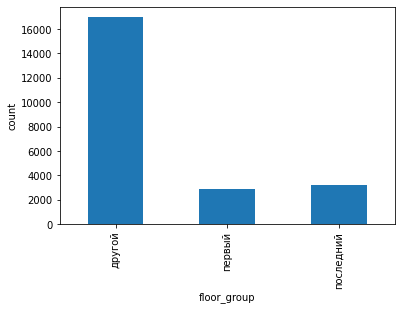

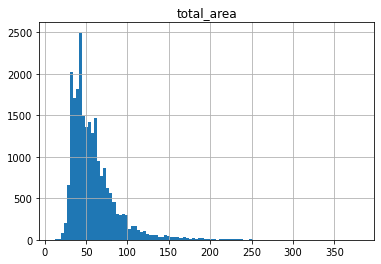

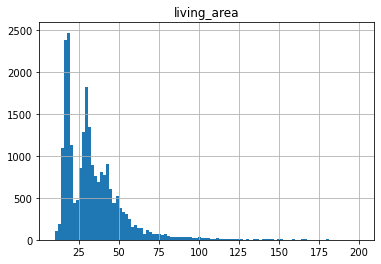

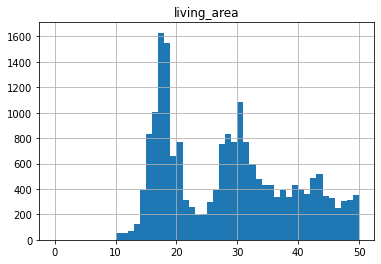

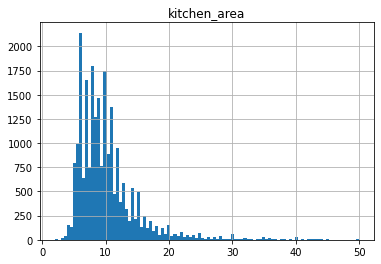

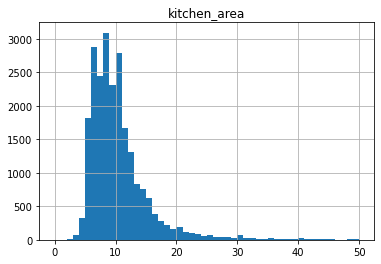

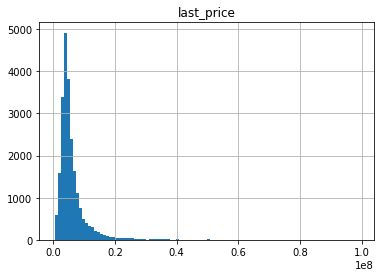

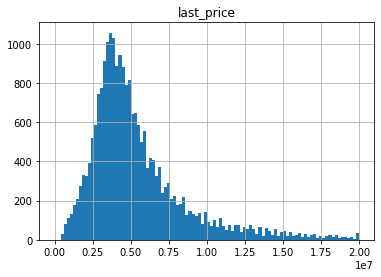

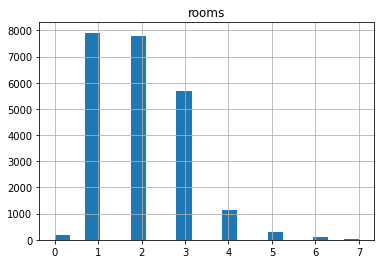

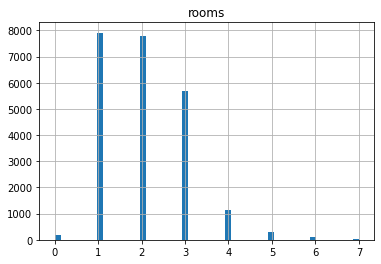

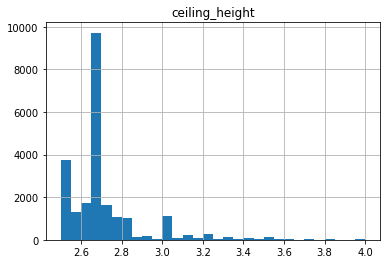

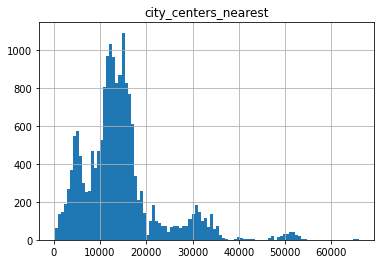

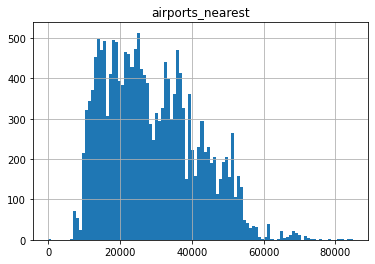

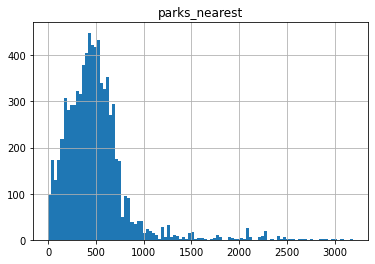

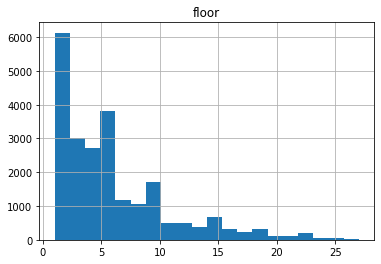

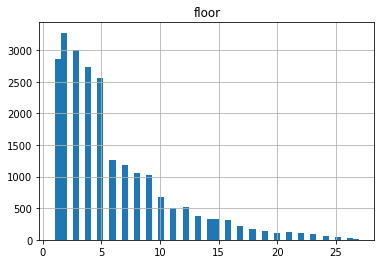

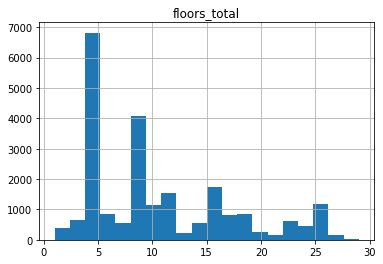

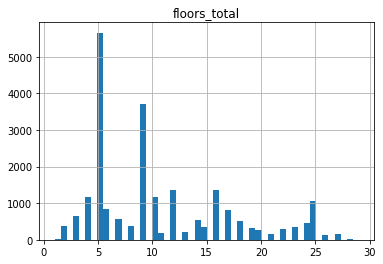

In [41]:
# Изучим данные, найдем закономерности и прочее с помощью графиков

# Тип этажа квартиры
data.groupby(by='floor_group')['floor_group'].count().plot(kind='bar', ylabel = 'count');

# Площадь кухни
data.hist('total_area', bins=100);

# Жилая площадь
data.hist('living_area', bins=100);
data.hist('living_area', bins=50, range=(0,50))

# Площадь кухни
data.hist('kitchen_area', bins=100);
data.hist('kitchen_area', bins=50, range=(0,50));

# Цена объекта
data.hist('last_price', bins=100);
data.hist('last_price', bins=100, range=(0,2e+07));

# Кол-во комнат
data.hist('rooms', bins=20);
data.hist('rooms', bins=50);
# Высота потолков
data.hist('ceiling_height', bins=30);

# Расстояние до центра города
data.hist('city_centers_nearest', bins=100);

# Расстояние до аэропорта
data.hist('airports_nearest', bins=100);

# Расстояние до ближайшего парка
data.hist('parks_nearest', bins=100);

# Этаж
data.hist('floor',  bins=20);
data.hist('floor',  bins=50);

# Общее количество этажей в доме
data.hist('floors_total', bins=20);
data.hist('floors_total', bins=50);


Построили гистограммы для:

— тип этажа квартиры («первый», «последний», «другой») в этом случае используем тип bar;
Больше всего квартир на "другом" этаже и это логично. Первых и последних этажей одинакого мало.

— общая площадь; Наблюдаем очень малое количество квартир с общей площадью более 100 кв.м. Если построить "ящик с усами" явно будет немного значений которые покажутся выбросами, но это просто элитная недвижимость.
жилая площадь; Наблюдаем два пика - на 18 кв.м. и на 30 кв.м. Нужно проверить, почему у нас именно два пика и почему есть явный провал около 24 кв.м.

— площадь кухни; Площадь кухни выглядит хорошо.

— цена объекта; Цена объекта выглядит хорошо. Немного "шумный" график. Очень длинный "хвост" вправо - это похоже илитная недвижимость.

— количество комнат; Больше всего двух- и трёх-комнатных квартир, но встречаются и редкие исключения.
высота потолков; Здесь два пика 2.5м и 3м, что логично.

— этаж квартиры; Больше всего квартир с 1 по 5 этаж. Логино, питер не город небоскрёбов

— общее количество этажей в доме; Видим явные пики: 5-этажная застройка, 9-этажная застройка, и небольшие пики более высоких новостроек.

— расстояние до центра города в метрах; Здесь наблюдаем два пика, один маленький, 5км и другой побльшой от 10 км. до 15 км. Так же есть совсем небольшие всплески на 30 км. и 50 км.

— расстояние до ближайшего аэропорта; Здесь видим довольно "шумный" график. Но это вполне нормально.

— расстояние до ближайшего парка; Судя по графику больше всего квартир с парками на расстоянии до 750м.

In [42]:
data['days_exposition'].isna().sum()

3117

Среднее время продажи квартиры(в днях): 171.3628398337756
Медианное время продажи квартиры(в днях): 93.0


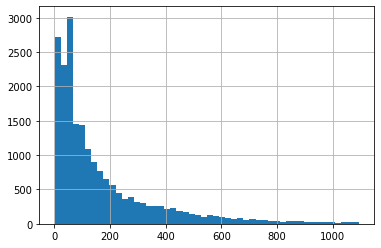

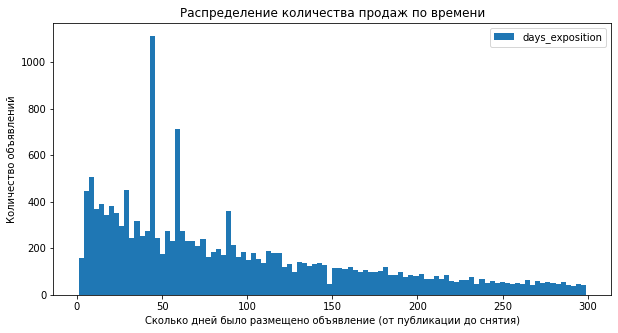

In [43]:
# Изучим, как быстро продавались квартиры (столбец `days_exposition`)
data['days_exposition'].hist(bins=50); # Для начала построим гистограмму

# Найдем среднее и медианное время продажи квартиры в днях
kv_mean = data['days_exposition'].mean()
kv_median =  data['days_exposition'].median()
print(f'Среднее время продажи квартиры(в днях): {kv_mean}')
print(f'Медианное время продажи квартиры(в днях): {kv_median}')

# Далее определим,сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими
data = data.query('days_exposition < 300') # как видно по прошлому графику, большинство квартир продаётся за менее чем 300 дней

data.plot(kind='hist',y='days_exposition',title='Распределение количества продаж по времени', bins=100, figsize=(10,5))

plt.xlabel('Сколько дней было размещено объявление (от публикации до снятия)')
plt.ylabel('Количество объявлений')
plt.show()

Можно сказать, что среднее время продажи квартиры составляет 171 день или почти целые полгода. Но если взять медиану - то это уже 93 дней, в два раза меньше. Почему так? Потому что у нас есть "длинный хвост" квартир, которые продавались очень долго, буквально годами. Я бы предложил считать быстрыми продажи до 93 дней, а необычно долгими - свыше 171 дня. Выбросы похожи на платные объявлени с истекшим сроком размещения или работу ситемы удаления неактивных объявлений

In [45]:
# Сейчас определим факторы, которые больше всего влияют на общую (полную) стоимость объекта
list_for_graph = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms',
                  ]

for entry in list_for_graph:
    correlation = data['last_price'].corr(data[entry])
    print(f'Корреляция между last_price и {entry} составляет: {correlation:0.2%}')

Корреляция между last_price и total_area составляет: 73.96%
Корреляция между last_price и living_area составляет: 65.09%
Корреляция между last_price и kitchen_area составляет: 55.84%
Корреляция между last_price и rooms составляет: 45.87%


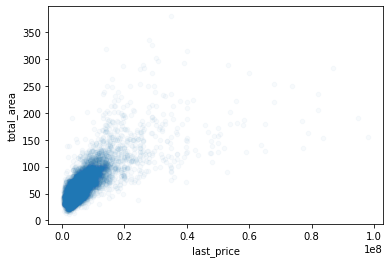

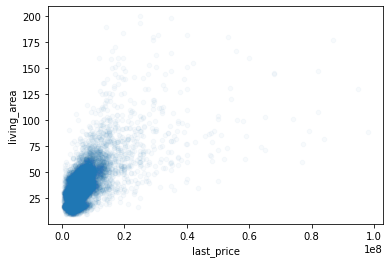

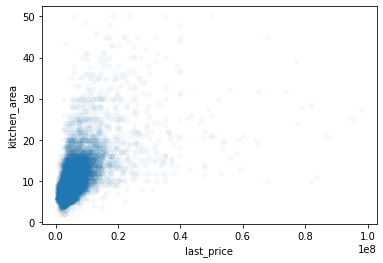

In [46]:
# Построим графики (площадь)
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.03);
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.03);
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.03);

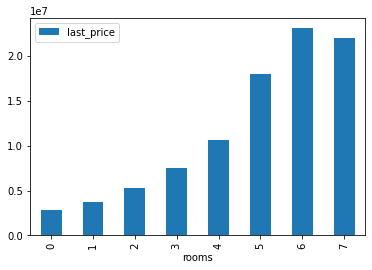

In [47]:
# Построим графики (комнаты)
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar');

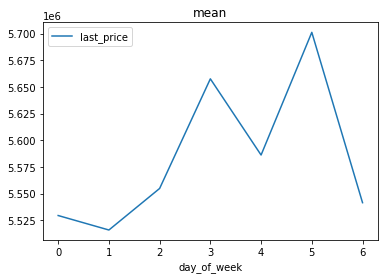

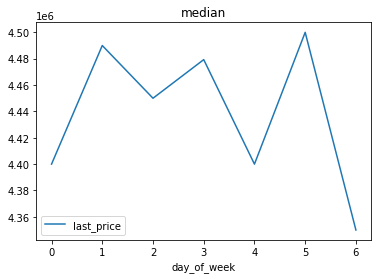

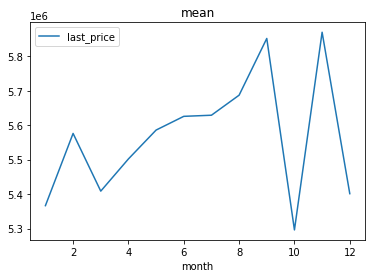

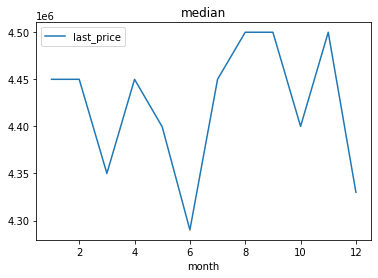

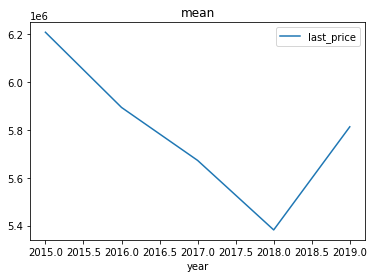

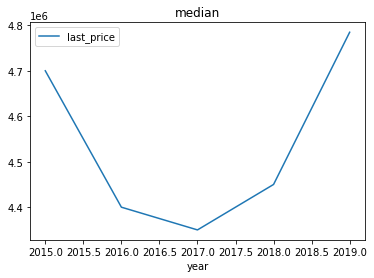

In [48]:
# Построим графики (день/месяц/год)
data.pivot_table(index='day_of_week',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='day_of_week',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='month',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='month',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='year',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='year',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

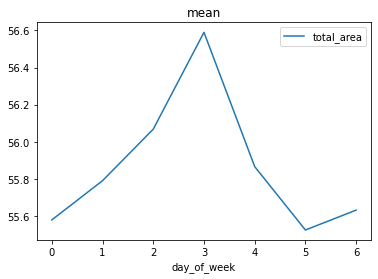

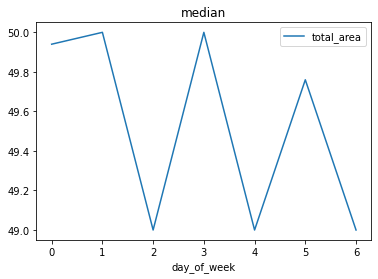

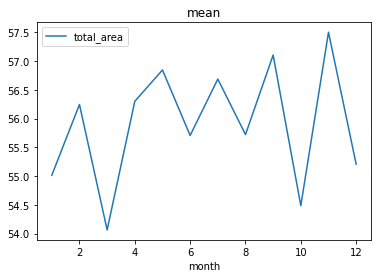

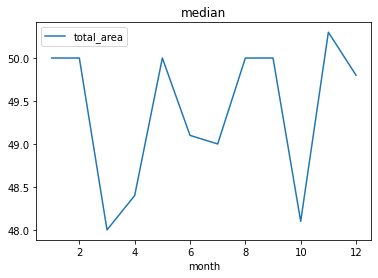

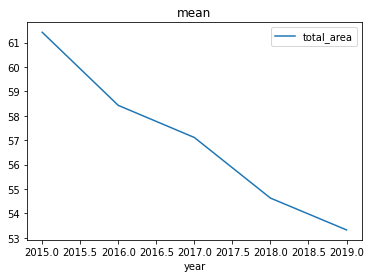

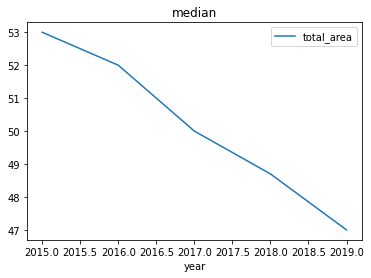

In [49]:
# Построим графики (площадь)
data.pivot_table(index='day_of_week',values='total_area',aggfunc='mean').plot(y='total_area', kind='line', title='mean');
data.pivot_table(index='day_of_week',values='total_area',aggfunc='median').plot(y='total_area', kind='line', title='median');

data.pivot_table(index='month',values='total_area',aggfunc='mean').plot(y='total_area', kind='line', title='mean');
data.pivot_table(index='month',values='total_area',aggfunc='median').plot(y='total_area', kind='line', title='median');

data.pivot_table(index='year',values='total_area',aggfunc='mean').plot(y='total_area', kind='line', title='mean');
data.pivot_table(index='year',values='total_area',aggfunc='median').plot(y='total_area', kind='line', title='median');

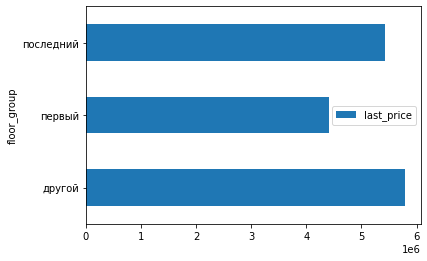

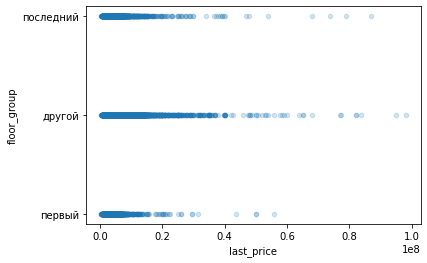

In [50]:
# Построим графики (тип этажа)
data.pivot_table(index='floor_group',values='last_price').plot(y='last_price', kind='barh');

data.plot(x='last_price', y='floor_group', kind='scatter', alpha=0.2);

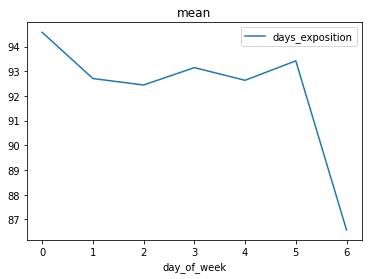

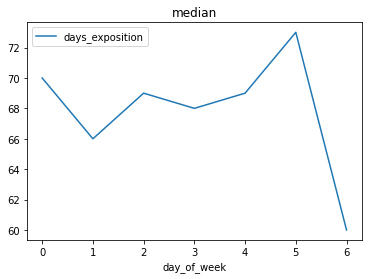

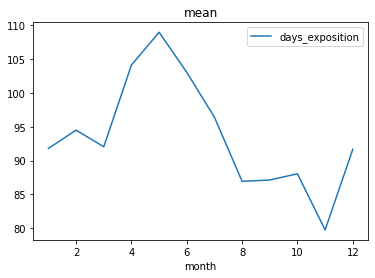

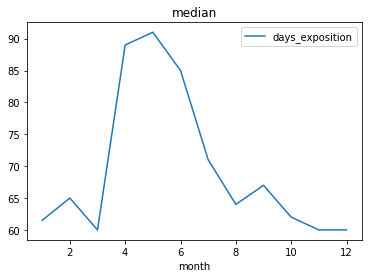

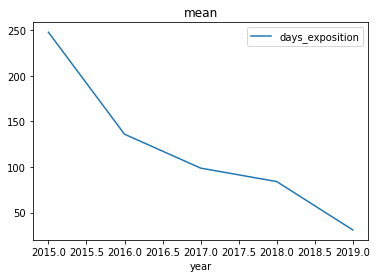

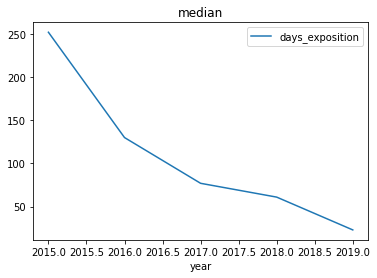

In [51]:
# Построим графики (объявления)
data.pivot_table(index='day_of_week',values='days_exposition',aggfunc='mean').plot(y='days_exposition', kind='line', title='mean');
data.pivot_table(index='day_of_week',values='days_exposition',aggfunc='median').plot(y='days_exposition', kind='line', title='median');

data.pivot_table(index='month',values='days_exposition',aggfunc='mean').plot(y='days_exposition', kind='line', title='mean');
data.pivot_table(index='month',values='days_exposition',aggfunc='median').plot(y='days_exposition', kind='line', title='median');

data.pivot_table(index='year',values='days_exposition',aggfunc='mean').plot(y='days_exposition', kind='line', title='mean');
data.pivot_table(index='year',values='days_exposition',aggfunc='median').plot(y='days_exposition', kind='line', title='median');

Как видим, цена зависит от:

- общей площади;
- жилой площади;
- площади кухни;
- количества комнат.

 И цена практически на зависит от:
 
- этажа, на котором расположена квартира;
- даты размещения.

Также стоит отметить, что с годами достаточно сильно упало среднее кол-во объявлений, а также средняя площадь квартир

Cредняя цена одного квадратного метра в топ-10 населенных пунктах

sum                 count           
                last_price total_area last_price total_area
locality_name                                              
бокситогорск    10699000.0     627.50         13         13
волосово        40050000.0    1015.45         20         20
волхов         120560000.0    3525.30         73         73
всеволожск     991582402.0   14683.66        269        269
выборг         510844000.0    9041.00        169        169
...                    ...        ...        ...        ...
сосновый бор   255417240.0    3437.30         67         67
сясьстрой       23310000.0     681.20         14         14
тихвин          68949000.0    1773.65         36         36
тосно          234874999.0    4061.30         77         77
шлиссельбург    97194000.0    1701.90         33         33

[270 rows x 4 columns]

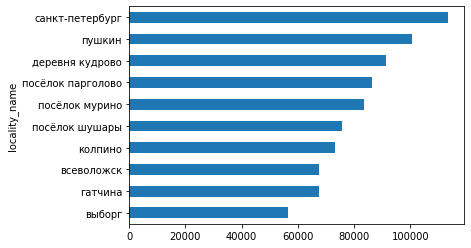

In [52]:
top_10 = data.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
display(top_10)
top_10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count']
top_10.pop('total_area_count')
top_10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
top_10 = top_10.iloc[:10]
top_10['price_per_sq_m'] = top_10['last_price_sum']/top_10['total_area_sum']
top_10.sort_values(by=['price_per_sq_m'],ascending=True, inplace=True)
top_10['price_per_sq_m'].plot(kind='barh');

Ожидаемо самая дорогая недвижимость в Санкт-Петербурге, минимальное же значение у Выборга. В ТОП-10 входят ближайшие к Санкт-Петербургу города.

Расстояние до центра города

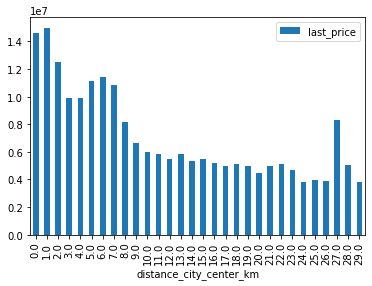

In [53]:
(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='distance_city_center_km',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
);

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_square_meter_price,day_of_week,month,year,floor_group,distance_city_center_km
439,9,8570000.0,72.00,2018-08-11,3,3.00,6,42.000000,4,False,...,NaN,0.0,NaN,149.0,119027.777778,5,8,2018,другой,27.0
556,0,3500000.0,28.50,2018-06-06,1,2.50,5,16.000000,4,False,...,NaN,0.0,NaN,86.0,122807.017544,2,6,2018,другой,27.0
558,13,4500000.0,65.50,2017-10-27,3,2.60,10,42.000000,7,False,...,NaN,0.0,NaN,32.0,68702.290076,4,10,2017,другой,27.0
748,13,14350000.0,74.00,2017-11-28,2,3.13,5,30.000000,3,False,...,1496.0,0.0,NaN,128.0,193918.918919,1,11,2017,другой,27.0
931,8,6650000.0,69.00,2017-06-20,3,3.20,3,50.000000,2,False,...,27.0,0.0,NaN,261.0,96376.811594,1,6,2017,другой,27.0
1719,12,4200000.0,38.00,2018-02-12,1,2.70,4,17.000000,3,False,...,311.0,3.0,557.0,162.0,110526.315789,0,2,2018,другой,27.0
1904,14,5150000.0,50.00,2018-11-11,2,2.65,3,30.000000,3,False,...,560.0,0.0,NaN,25.0,103000.000000,6,11,2018,последний,27.0
2104,11,3150000.0,32.00,2018-02-25,1,2.65,5,18.400000,3,False,...,NaN,0.0,NaN,127.0,98437.500000,6,2,2018,другой,27.0
2409,4,1980000.0,27.00,2018-03-23,0,2.65,18,15.421695,4,False,...,NaN,2.0,663.0,75.0,73333.333333,4,3,2018,другой,27.0
2460,15,7500000.0,78.00,2018-09-19,3,3.00,3,50.000000,2,False,...,394.0,3.0,279.0,166.0,96153.846154,2,9,2018,другой,27.0


<AxesSubplot:>

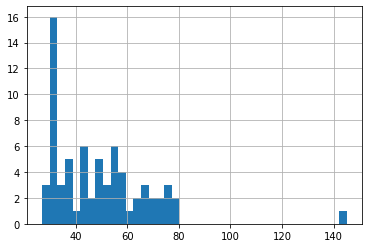

In [54]:
km_27 = data.query('distance_city_center_km == 27')
display(km_27.head(20))
display(km_27['total_area'].hist(bins=40))

floor_group,другой,первый,последний
distance_city_center_km,,,
0.0,70.000000,20.000000,10.000000
1.0,60.000000,13.333333,26.666667
2.0,55.747126,17.816092,26.436782
3.0,59.693878,16.836735,23.469388
4.0,71.688312,12.727273,15.584416
5.0,75.806452,10.282258,13.911290
6.0,75.968992,11.627907,12.403101
7.0,80.459770,5.747126,13.793103
8.0,78.660050,8.436725,12.903226


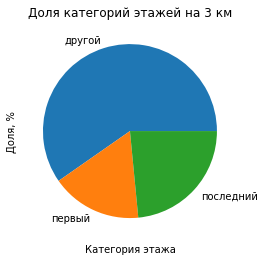

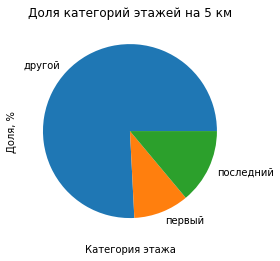

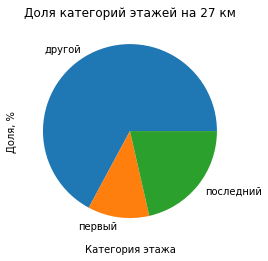

In [55]:
# Выбор нужных расстояний
selected_distances = [3, 5, 27]

# Группировка данных по расстоянию и категории квартиры
grouped_data = data.groupby(['distance_city_center_km', 'floor_group']).size().unstack()

# Создание сводной таблицы с долями
percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
display(percentage_data)
# Построение гистограммы для каждого выбранного расстояния
for distance in selected_distances:
    data_for_distance = percentage_data.loc[distance].dropna()
    data_for_distance.plot(kind='pie', title=f'Доля категорий этажей на {distance} км')
    plt.xlabel('Категория этажа')
    plt.ylabel('Доля, %')
    plt.show()

Недвижимость в пределах 1 километра является явным лидером с большим отрывом.

Наблюдается более низкая стоимость жилья на расстоянии от 1 до 7 километров.

Далее, на протяжении от 8 до 27 километров, цены на недвижимость уменьшаются, это говорит нам, 
что центральным районом можно считать все квартиры в удалении от центра не более чем на 7 км.

Однако на 27 километрах мы видим пик, который сложно объяснить, возможно,
это связано с особым районом, где располагается эта недвижимость, так как в целом он ничем не отоичается от остальных.

Если же говорить про 3 и 5 км, то, возможно, разница из-за того, что на 3-м км продаётся больше квартир на 1-м этаже

### Общий вывод

Итак, в ходе изучения таблицы, была проведена необходимая предобработка данных, были найдены и удалены пропуски,
найдены и заменены артефакты и аномалии, а также заменены неявные дубликаты. Все эти действия позволили провести исследоваткльский анализ. 

Из необычных особенностей:

В 27 км от центра Санкт-Петербурга есть недвижимость по цене почти равная недвижимости в 8 км. от центра;

В ТОП-10 входят в основном ближайшие к Санкт-Петербургу города и самые крупные города области:
Пушкин; Гатчина; Всеволожск; Выборг.

Было выявлено, что такие факторы как общая площадь квартиры, жилая площадь и непосредственно
площадь кухни, а так же количество комнат прямо влияют на общую конечную стоимость объекта недвижтимости. А вот тип этажа, на котором располагается объект, не в значительной степени либо вообще никак не влияет на его стоимость, так же как и дата опубликования объявления его продаже(день, месяц или год)

Быстрые продажи это до 93 дней, а необычно долгие - свыше 171 дня.